# Example Notebook for Keysight Network Analyzers

This notebook is indendet to give an overview over the functions implemented in the QCoDeS driver for the Keysight network analyzers. The driver is implemented to be generic as possible, with individual instrument drivers filling in only the hardware limits of the instrument, so although this example uses the N5245A, the concepts and code should work for any keysight network analyzer.

In [1]:
%matplotlib inline

In [2]:
# Import Dependencies

import logging
import matplotlib.pyplot as plt

# qcodes imports
import qcodes as qc
from qcodes.dataset.data_set import new_data_set
from qcodes.dataset.experiment_container import new_experiment, load_experiment_by_name
from qcodes.dataset.measurements import Measurement
from qcodes.dataset.plotting import plot_by_id
from qcodes.instrument_drivers.Keysight.N52xx import PNAxBase

In [3]:
#setup
#logger = logging.getLogger()
#logger.setLevel(logging.DEBUG)

qc.initialise_database()

# Start experiment
exp_name = 'PNA_Example_N5222B'
sample_name = 'sample_bar_code'
try:
    exp = load_experiment_by_name(exp_name, sample=sample_name)
    print('Experiment loaded. Last ID no:', exp.last_counter)
except ValueError:
    exp = new_experiment(exp_name, sample_name)
    print('Starting new experiment.')

Experiment loaded. Last ID no: 2


In [4]:
class N5222B(PNAxBase): 
    def __init__(self, name, address, **kwargs):
        super().__init__(name, address,
                         min_freq=10.E6, max_freq=26.5E9,
                         min_power=-90, max_power=12,
                         nports=2,
                         **kwargs)

## Connect to the instrument

You will have to insert the correct VISA address for your PNA below. On my PC, the PNA has IP address `192.168.0.10`. You can generally use NI MAX or Agilent IO Toolkit to figure out what the VISA address of your instrument is, particularly for USB or GPIB connections.

In [5]:
pna = N5222B('pna', 'GPIB0::16::INSTR')

Connected to: Keysight Technologies N5222B (serial:MY57041028, firmware:A.13.25.04) in 0.18s


## Simple Measurements

We can very easily set up measurements and pull, for example, magnitude data off the PNA.

Starting experimental run with id: 18


([<matplotlib.axes._subplots.AxesSubplot at 0x28669ded198>], [None])

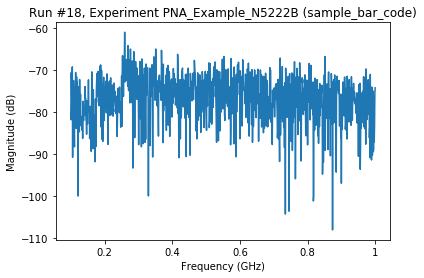

In [7]:
# set the trigger source to internal 
pna.trigger_source("INT")
# Set up a frequency sweep from 100 MHz to 1 GHz, with 1001 points, at a power of -40dBm
pna.power(-40)
pna.start(100e6)
pna.stop(1e9)
pna.points(1001)
#pna.trace("S21")

# Enable 2 averages, and set IF BW to 1kHz
pna.if_bandwidth(1e3)
pna.averages_enabled(True)
pna.averages(2)

# Run a measurement
meas = Measurement()
meas.register_parameter(pna.magnitude)

with meas.run() as datasaver:
    mag = pna.magnitude()
    datasaver.add_result((pna.magnitude, mag))
    dataid = datasaver.run_id
plot_by_id(dataid)

# Other valid parameter types are:
# pna.linear_magnitude()
# pna.phase()
# pna.unwrapped_phase()
# pna.group_delay()
# pna.real()
# pna.imaginary()

## Reading multiple parameters in one measurement

If we want to read out multiple parameters in a single loop, we can disable auto-sweep and manually tell the PNA to take new data for each setpoint. Otherwise, each time we get a measured parameter of the PNA (e.g. magnitude and phase) a new trace will be taken.

Starting experimental run with id: 14


([<matplotlib.axes._subplots.AxesSubplot at 0x241ddb2d908>,
 [None, None])

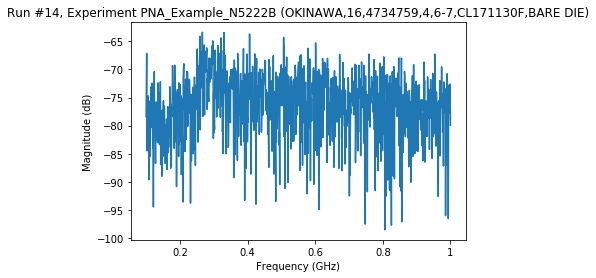

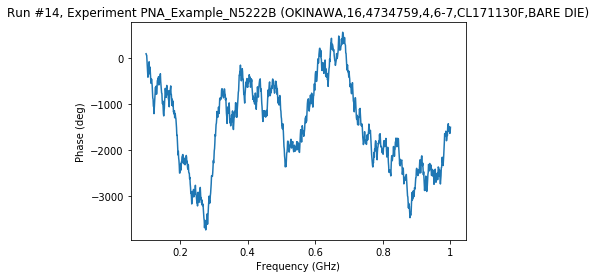

In [7]:
# Disable automatic sweeping
pna.auto_sweep(False)

# Run a measurement
meas = Measurement()
meas.register_parameter(pna.magnitude)
meas.register_parameter(pna.phase)

with meas.run() as datasaver:
    pna.traces.tr1.run_sweep() # Ask the PNA to take a measurement
    mag = pna.magnitude()
    phase = pna.unwrapped_phase()
    datasaver.add_result((pna.magnitude, mag),
                         (pna.phase, phase))
    dataid = datasaver.run_id
plot_by_id(dataid)

## Multiple Traces

We can also read multiple traces off the PNA at once. For example if the PNA is set up such that:
 - Trace 1 is S11
 - Trace 2 is S12
 - Trace 3 is S21
 - Trace 4 is S22
 
we can read these off simultaneously as follows:

Starting experimental run with id: 20


([<matplotlib.axes._subplots.AxesSubplot at 0x1ba0d6aca58>,
 [None, None, None, None])

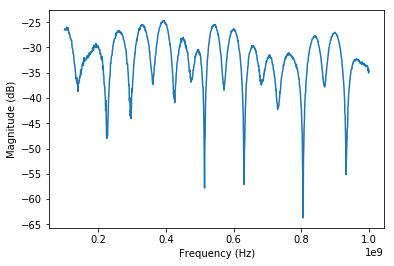

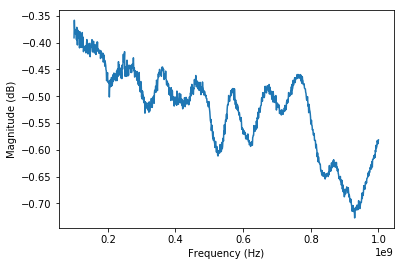

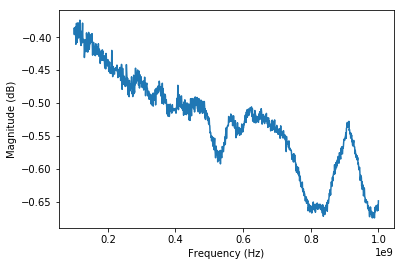

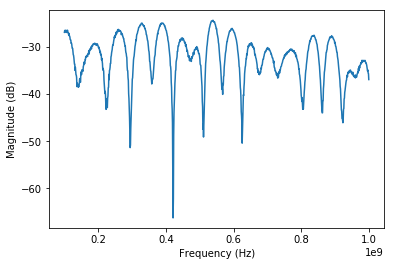

In [7]:
# Disable automatic sweeping
pna.auto_sweep(False)

# Update the list of traces
traces = pna.traces

# Run a measurement
meas = Measurement()
meas.register_parameter(traces.tr1.magnitude)
meas.register_parameter(traces.tr2.magnitude)
meas.register_parameter(traces.tr3.magnitude)
meas.register_parameter(traces.tr4.magnitude)

with meas.run() as datasaver:
    traces.tr1.run_sweep() # Ask the PNA to take a measurement
    data = []
    for trace in traces:
        mag = trace.magnitude()
        data.append((trace.magnitude, mag))
    datasaver.add_result(*data)
    dataid = datasaver.run_id
plot_by_id(dataid)

In [8]:
# Set the PNA back into continuous sweep mode
pna.sweep_mode("CONT")

In [8]:
try: 
    while True: 
        pass 
except KeyboardInterrupt: 
    print("got tired?")

got tired?
